# Exploratory Data Analysis Pt 2

## Model Activations

In this second part of the EDA, I'm taking a look at the data produced by [Essentia's models](https://essentia.upf.edu/models.html)

In [87]:
#Imports
import sqlite3
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from glob import glob
from tqdm import tqdm
import pathlib
import librosa
import taglib
from IPython.lib.display import YouTubeVideo
import warnings
warnings.filterwarnings('ignore')

In [2]:
#Imports from project package called project_tools
from project_tools.utils import adapt_array, convert_array, tag_cleaner, json_opener

In [3]:
#Register these functions with sqlite3 so that we I can work with 
sqlite3.register_adapter(np.ndarray, adapt_array)
sqlite3.register_converter("array", convert_array)

In [4]:
#Connect to db
conn = sqlite3.connect("jaage.db", detect_types= sqlite3.PARSE_DECLTYPES)
cur = conn.cursor()

Here are the tables in my database

In [5]:
tables = pd.read_sql_query("SELECT name FROM sqlite_master WHERE type='table'", con = conn)
tables

,name
0,effnet_embeddings
1,files
2,tonal_features
3,lowlevel_features
4,rhythm_features
5,approachability_2c_effnet_discogs_1_activations
6,danceability_effnet_discogs_1_activations
7,engagement_2c_effnet_discogs_1_activations
8,genre_electronic_effnet_discogs_1_activations
9,mood_acoustic_effnet_discogs_1_activations


Load in tags data as well 

In [6]:
tags = pd.read_sql_query("SELECT * FROM tags", con = conn).set_index("sid")
tags.head()

,length,gain,codec,file_name,bpm,initialkey,title,album,artist,date,genre,label
sid,,,,,,,,,,,,
b806881a54bdbf9dd93a290716adf191,287.393372,-9.895140,pcm_s16le,04 House Of Love_PN.wav,119.0,6A,04 House Of Love_PN,None,None,None,None,None
46e54d2ab920a088b77382e04877141b,311.251892,-11.281836,pcm_s16le,Alex Virgo - Rough N' Ready Edits - 06 A.T.S -...,128.0,1A,A.T.S - Baa Daa Laa (Alex Virgo's Rough n Read...,Rough N' Ready Edits,Alex Virgo,2020,None,None
a204ddef5763df6d8f7677701fe9d96f,415.114746,-9.958479,pcm_s16le,01 Protostar_PN.wav,117.0,5A,Protostar,Planetary Groove,FROM BEYOND,2020,None,None
960097894e83c5810a9c649f17a4e551,321.108765,-12.223524,pcm_s16le,Cristal - Drink My Soul (Running Hot Edit)_PN.wav,0.0,None,None,None,None,None,None,None
a3c1f277aa0110ffc418bf5fa3aa16aa,378.276276,-12.410757,pcm_s16le,Maya - Lait De Coco ( Les Yeux Orange Edit)_PN...,109.0,6A,Maya - Lait De Coco ( Les Yeux Orange Edit)_PN,None,None,2016,None,None


In [7]:
activations_tables = tables[tables.name.str.contains("activations") ].name.tolist()
activations_tables

['approachability_2c_effnet_discogs_1_activations',
 'danceability_effnet_discogs_1_activations',
 'engagement_2c_effnet_discogs_1_activations',
 'genre_electronic_effnet_discogs_1_activations',
 'mood_acoustic_effnet_discogs_1_activations',
 'mood_aggressive_effnet_discogs_1_activations',
 'mood_happy_effnet_discogs_1_activations',
 'mood_party_effnet_discogs_1_activations',
 'mood_sad_effnet_discogs_1_activations',
 'mtg_jamendo_genre_effnet_discogs_1_activations',
 'mtg_jamendo_moodtheme_effnet_discogs_1_activations',
 'mtg_jamendo_top50tags_effnet_discogs_1_activations',
 'timbre_effnet_discogs_1_activations']

Add the effnet genre activations as well

In [8]:
activations_tables += ['effnet_genres']

Going into this project I was bullish that these models could accurately appraise certain acoustic qualities and traits in music but I was always going to need to apply an ear test to see how well they work on my music collection.

In this notebook I go through each of model activations and assess how well they are rating how "happy" or "aggressive" a song is or how good they are are identifying obscure genres of music.

### [Effnet Genres](https://essentia.upf.edu/models.html#discogs-effnet)

"Prediction of the top-400 music styles in the Discogs-4M dataset (unreleased)",

[Model metadata](https://essentia.upf.edu/models/music-style-classification/discogs-effnet/discogs-effnet-bs64-1.json)

In [9]:
effnet_genres = pd.read_sql_query("SELECT * FROM effnet_genres", 
                                  con = conn).set_index("sid").applymap(lambda x:x[0])
effnet_genres.head()

,blues___boogie_woogie,blues___chicago_blues,blues___country_blues,blues___delta_blues,blues___electric_blues,blues___harmonica_blues,blues___jump_blues,blues___louisiana_blues,blues___modern_electric_blues,blues___piano_blues,...,rock___symphonic_rock,rock___technical_death_metal,rock___thrash,rock___twist,rock___viking_metal,rock___yé_yé,stage__screen___musical,stage__screen___score,stage__screen___soundtrack,stage__screen___theme
sid,,,,,,,,,,,,,,,,,,,,,
b806881a54bdbf9dd93a290716adf191,"[4.172325e-07, 1.4007092e-06, 7.1525574e-07, 4...","[8.046627e-06, 1.7791986e-05, 9.953976e-06, 1....","[6.556511e-07, 3.695488e-06, 3.2782555e-06, 1....","[9.23872e-07, 3.9041042e-06, 3.0994415e-06, 1....","[5.155802e-06, 1.5765429e-05, 1.7374754e-05, 1...","[8.34465e-07, 1.6093254e-06, 6.2584877e-07, 1....","[1.7881393e-07, 5.662441e-07, 8.34465e-07, 3.2...","[2.682209e-07, 9.834766e-07, 6.2584877e-07, 8....","[1.4424324e-05, 4.7773123e-05, 3.0219555e-05, ...","[1.7881393e-06, 4.2021275e-06, 2.4437904e-06, ...",...,"[6.467104e-06, 3.3050776e-05, 1.13248825e-05, ...","[5.9604645e-08, 8.940697e-07, 2.0861626e-07, 5...","[2.503395e-06, 1.1473894e-05, 4.3809414e-06, 9...","[1.9669533e-06, 2.026558e-06, 2.592802e-06, 1....","[1.1920929e-07, 3.5762787e-07, 1.7881393e-07, ...","[3.2782555e-07, 7.748604e-07, 2.3841858e-07, 9...","[4.053116e-06, 2.0772219e-05, 4.5895576e-06, 1...","[9.447336e-06, 0.00013121963, 1.1473894e-05, 6...","[0.00019520521, 0.0010717809, 0.0003451407, 0....","[3.707409e-05, 0.00019714236, 0.00012657046, 0..."
46e54d2ab920a088b77382e04877141b,"[9.23872e-07, 1.1622906e-06, 5.364418e-07, 7.7...","[2.1755695e-06, 1.9967556e-06, 9.23872e-07, 6....","[8.940697e-07, 1.937151e-06, 3.5762787e-07, 2....","[2.0861626e-07, 4.4703484e-07, 1.7881393e-07, ...","[5.811453e-06, 3.963709e-06, 3.3080578e-06, 9....","[6.854534e-07, 1.6987324e-06, 6.2584877e-07, 3...","[8.6426735e-06, 5.4240227e-06, 3.8444996e-06, ...","[5.9604645e-08, 1.4901161e-07, 5.9604645e-08, ...","[2.3543835e-06, 2.8312206e-06, 2.2351742e-06, ...","[2.9802322e-07, 8.6426735e-07, 2.3841858e-07, ...",...,"[1.5199184e-05, 2.4795532e-05, 1.2069941e-05, ...","[1.937151e-06, 2.8908253e-06, 1.1920929e-06, 1...","[3.454089e-05, 2.348423e-05, 1.4036894e-05, 6....","[1.6093254e-05, 8.374453e-06, 1.6182661e-05, 7...","[1.9073486e-06, 1.8775463e-06, 8.34465e-07, 8....","[9.804964e-06, 1.6123056e-05, 9.745359e-06, 4....","[3.0875206e-05, 3.9756298e-05, 1.79708e-05, 1....","[2.631545e-05, 0.00012886524, 2.2679567e-05, 5...","[0.00011396408, 0.00060740113, 8.332729e-05, 0...","[1.7255545e-05, 7.215142e-05, 1.0460615e-05, 1..."
a204ddef5763df6d8f7677701fe9d96f,"[1.758337e-06, 6.0796738e-06, 5.2452087e-06, 6...","[2.2023916e-05, 2.4616718e-05, 2.1070242e-05, ...","[9.4771385e-06, 1.8805265e-05, 1.6480684e-05, ...","[6.1690807e-06, 1.2040138e-05, 5.8710575e-06, ...","[3.4481287e-05, 3.4362078e-05, 3.838539e-05, 2...","[7.1823597e-06, 3.33786e-06, 2.3305416e-05, 7....","[2.9802322e-06, 3.6656857e-06, 1.1026859e-06, ...","[3.2484531e-06, 3.1888485e-06, 2.592802e-06, 9...","[7.408857e-05, 6.586313e-05, 0.0001386702, 6.9...","[7.1525574e-07, 1.4007092e-06, 5.364418e-07, 6...",...,"[6.389618e-05, 0.00010052323, 5.760789e-05, 7....","[4.261732e-06, 2.8908253e-06, 2.5331974e-06, 2...","[1.04904175e-05, 7.301569e-06, 5.2452087e-06, ...","[4.708767e-06, 5.185604e-06, 3.4868717e-06, 3....","[2.503395e-06, 4.708767e-06, 1.3709068e-06, 2....","[7.033348e-06, 1.1712313e-05, 8.761883e-06, 7....","[3.6358833e-05, 5.2124262e-05, 5.5104494e-05, ...","[7.1525574e-05, 0.00012114644, 7.787347e-05, 0...","[0.0011410415, 0.0015925765, 0.0014226437, 0.0...","[8.380413e-05, 7.2181225e-05, 5.6028366e-05, 8..."
960097894e83c5810a9c649f17a4e551,"[2.9802322e-08, 0.0, 0.0, 5.9604645e-08, 1.192...","[2.3841858e-07, 2.0861626e-07, 5.364418e-07, 4...","[0.0, 0.0, 5.9604645e-08, 0.0, 8.940697e-08, 2...","[2.9802322e-08, 8.940697e-08, 5.9604645e-08, 1...","[1.5497208e-06, 1.0728836e-06, 2.503395e-06, 2...","[2.0861626e-0

In [10]:
song1 = effnet_genres.iloc[0]
song1

blues___boogie_woogie         [4.172325e-07, 1.4007092e-06, 7.1525574e-07, 4...
blues___chicago_blues         [8.046627e-06, 1.7791986e-05, 9.953976e-06, 1....
blues___country_blues         [6.556511e-07, 3.695488e-06, 3.2782555e-06, 1....
blues___delta_blues           [9.23872e-07, 3.9041042e-06, 3.0994415e-06, 1....
blues___electric_blues        [5.155802e-06, 1.5765429e-05, 1.7374754e-05, 1...
                                                    ...                        
rock___yé_yé                  [3.2782555e-07, 7.748604e-07, 2.3841858e-07, 9...
stage__screen___musical       [4.053116e-06, 2.0772219e-05, 4.5895576e-06, 1...
stage__screen___score         [9.447336e-06, 0.00013121963, 1.1473894e-05, 6...
stage__screen___soundtrack    [0.00019520521, 0.0010717809, 0.0003451407, 0....
stage__screen___theme         [3.707409e-05, 0.00019714236, 0.00012657046, 0...
Name: b806881a54bdbf9dd93a290716adf191, Length: 400, dtype: object

Each song row has an array of N-length whose values representing the activation scores for that model's label. Each value in that row is the score for a small sample for that original song, in this example it represents 2 seconds of data. N is product of the song's length and other settings used in the creation of the spectrograms used to train this and other models.

In [11]:
song1.apply(len)

blues___boogie_woogie         140
blues___chicago_blues         140
blues___country_blues         140
blues___delta_blues           140
blues___electric_blues        140
                             ... 
rock___yé_yé                  140
stage__screen___musical       140
stage__screen___score         140
stage__screen___soundtrack    140
stage__screen___theme         140
Name: b806881a54bdbf9dd93a290716adf191, Length: 400, dtype: int64

Effnet cols are organized by general genre and sub genre

In [12]:
effnet_cols = effnet_genres.columns
effnet_cols

Index(['blues___boogie_woogie', 'blues___chicago_blues',
       'blues___country_blues', 'blues___delta_blues',
       'blues___electric_blues', 'blues___harmonica_blues',
       'blues___jump_blues', 'blues___louisiana_blues',
       'blues___modern_electric_blues', 'blues___piano_blues',
       ...
       'rock___symphonic_rock', 'rock___technical_death_metal',
       'rock___thrash', 'rock___twist', 'rock___viking_metal', 'rock___yé_yé',
       'stage__screen___musical', 'stage__screen___score',
       'stage__screen___soundtrack', 'stage__screen___theme'],
      dtype='object', length=400)

In [13]:
genre_groups = effnet_cols.str.split("___").map(lambda x:x[0]).unique()
genre_groups

Index(['blues', 'brass__military', 'childrens', 'classical', 'electronic',
       'folk_world__country', 'funk__soul', 'hip_hop', 'jazz', 'latin',
       'non_music', 'pop', 'reggae', 'rock', 'stage__screen'],
      dtype='object')

Here is a printed output of the general genre categories and their sub groups

In [14]:
genre_dict = {}

for genre in genre_groups:
    subgenres = effnet_cols[effnet_cols.str.startswith(genre)].str.split("___", expand =True).get_level_values(1).tolist()
    genre_dict[genre] = subgenres

In [15]:
for k, v in genre_dict.items():
    print(k, v, "\n")

blues ['boogie_woogie', 'chicago_blues', 'country_blues', 'delta_blues', 'electric_blues', 'harmonica_blues', 'jump_blues', 'louisiana_blues', 'modern_electric_blues', 'piano_blues', 'rhythm__blues', 'texas_blues'] 

brass__military ['brass_band', 'marches', 'military'] 

childrens ['educational', 'nursery_rhymes', 'story'] 

classical ['baroque', 'choral', 'classical', 'contemporary', 'impressionist', 'medieval', 'modern', 'neo_classical', 'neo_romantic', 'opera', 'post_modern', 'renaissance', 'romantic'] 

electronic ['abstract', 'acid', 'acid_house', 'acid_jazz', 'ambient', 'bassline', 'beatdown', 'berlin_school', 'big_beat', 'bleep', 'breakbeat', 'breakcore', 'breaks', 'broken_beat', 'chillwave', 'chiptune', 'dance_pop', 'dark_ambient', 'darkwave', 'deep_house', 'deep_techno', 'disco', 'disco_polo', 'donk', 'downtempo', 'drone', 'drum_n_bass', 'dub', 'dub_techno', 'dubstep', 'dungeon_synth', 'ebm', 'electro', 'electro_house', 'electroclash', 'euro_house', 'euro_disco', 'eurobeat', 

I definitely don't need all 400 genres here. There are several general categories that I won't miss if I drop them so let's go ahead and do that.

In [16]:
drop_categories = ['brass__military', 'childrens', 'classical', 'stage__screen','non_music',
                  'blues', "hip_hop", "rock"]

The remaining columns

In [17]:
effnet_cols = effnet_cols[~effnet_cols.str.split("___").map(lambda x:x[0]).isin(drop_categories)]
effnet_cols

Index(['electronic___abstract', 'electronic___acid', 'electronic___acid_house',
       'electronic___acid_jazz', 'electronic___ambient',
       'electronic___bassline', 'electronic___beatdown',
       'electronic___berlin_school', 'electronic___big_beat',
       'electronic___bleep',
       ...
       'reggae___dancehall', 'reggae___dub', 'reggae___lovers_rock',
       'reggae___ragga', 'reggae___reggae', 'reggae___reggae_pop',
       'reggae___rocksteady', 'reggae___roots_reggae', 'reggae___ska',
       'reggae___soca'],
      dtype='object', length=235)

This cleaves off almost half the data

Filter out the bad columns

In [18]:
effnet_genres = effnet_genres[effnet_cols]

I went through and filtered the irrelevant genres manually and saved the ones I want to keep to a pickle file.

In [58]:
keep_cols = np.load("keep_genre_cols.pkl", allow_pickle=True)
effnet_genres = effnet_genres[keep_cols]

Now we can move onto the analysis.

### The effectiveness of summary stats

The varying length of songs and of their model scores poses an interesting challenge. 

The simple way to analyze this data would be to produce a MxN matrix where each value is a single number. I can obviously do that by simply taking the mean of every array in each cell but I'd like to investigate how representative a mean would be of an array.

If I see that these arrays have low variances, then I can place more faith on the means as a representative value.

In [59]:
effnet_genre_mean = effnet_genres.applymap(lambda x:x.mean())
effnet_genre_std = effnet_genres.applymap(lambda x:x.std())

In [60]:
effnet_genre_mean.head()

,electronic___abstract,electronic___acid,electronic___acid_house,electronic___bassline,electronic___berlin_school,electronic___big_beat,electronic___breakbeat,electronic___breakcore,electronic___breaks,electronic___dance_pop,...,reggae___dancehall,reggae___dub,reggae___lovers_rock,reggae___ragga,reggae___reggae,reggae___reggae_pop,reggae___rocksteady,reggae___roots_reggae,reggae___soca,latin___baião
sid,,,,,,,,,,,,,,,,,,,,,
b806881a54bdbf9dd93a290716adf191,0.002877,0.006506,0.016385,0.005211,0.000771,0.003233,0.003858,0.000162,0.006960,0.018993,...,0.000513,0.000692,0.000171,0.000478,0.000450,0.000940,0.000066,0.000324,0.000282,7.050804e-06
46e54d2ab920a088b77382e04877141b,0.000848,0.068645,0.087726,0.003429,0.000745,0.008172,0.015414,0.000499,0.010561,0.003824,...,0.001796,0.000383,0.000243,0.001607,0.001491,0.001522,0.000216,0.000899,0.000765,1.663167e-05
a204ddef5763df6d8f7677701fe9d96f,0.002782,0.078910,0.073124,0.006942,0.001731,0.001360,0.004116,0.000164,0.012258,0.005171,...,0.000171,0.000511,0.000049,0.000089,0.000413,0.000316,0.000055,0.000076,0.000135,8.840962e-06
960097894e83c5810a9c649f17a4e551,0.000350,0.014691,0.093026,0.000031,0.000026,0.000821,0.008097,0.000029,0.001659,0.018397,...,0.000196,0.000285,0.000146,0.000967,0.000777,0.002066,0.000035,0.000217,0.001430,1.043081e-07
a3c1f277aa0110ffc418bf5fa3aa16aa,0.005110,0.001761,0.000758,0.000848,0.002481,0.000654,0.000588,0.000237,0.000672,0.003807,...,0.000772,0.001386,0.001452,0.000400,0.008080,0.004898,0.000512,0.001023,0.002463,2.356781e-05


In [61]:
effnet_genre_std.head()

,electronic___abstract,electronic___acid,electronic___acid_house,electronic___bassline,electronic___berlin_school,electronic___big_beat,electronic___breakbeat,electronic___breakcore,electronic___breaks,electronic___dance_pop,...,reggae___dancehall,reggae___dub,reggae___lovers_rock,reggae___ragga,reggae___reggae,reggae___reggae_pop,reggae___rocksteady,reggae___roots_reggae,reggae___soca,latin___baião
sid,,,,,,,,,,,,,,,,,,,,,
b806881a54bdbf9dd93a290716adf191,0.004489,0.007772,0.014888,0.015709,0.001294,0.003859,0.005045,0.000698,0.008932,0.030730,...,0.001047,0.001609,0.000436,0.000845,0.000944,0.001350,0.000237,0.000705,0.000508,5.724796e-05
46e54d2ab920a088b77382e04877141b,0.000813,0.056820,0.094107,0.004573,0.000983,0.015367,0.011851,0.000495,0.016902,0.003825,...,0.006851,0.001200,0.001055,0.005638,0.005017,0.003753,0.000845,0.003981,0.002683,6.986711e-05
a204ddef5763df6d8f7677701fe9d96f,0.002385,0.063384,0.043826,0.008950,0.002375,0.001916,0.004279,0.000426,0.009001,0.004638,...,0.000586,0.000706,0.000334,0.000399,0.001012,0.000657,0.000225,0.000388,0.000331,1.175568e-04
960097894e83c5810a9c649f17a4e551,0.000336,0.013034,0.054004,0.000054,0.000053,0.000963,0.004896,0.000036,0.001416,0.018803,...,0.000517,0.000463,0.000275,0.001754,0.001920,0.003982,0.000079,0.000349,0.007487,3.238680e-07
a3c1f277aa0110ffc418bf5fa3aa16aa,0.012423,0.007451,0.000873,0.002089,0.007096,0.000952,0.001566,0.000825,0.000741,0.003756,...,0.004869,0.002437,0.003627,0.002709,0.011493,0.006917,0.000863,0.004594,0.005556,6.748780e-05


Plot every mean vs every standard deviation. The red dotted line represents the border between an area where the mean is greater than the standard deviation and vice versa. It's preferable for dots to appear in the lower right half because that indicates a lower variance relative to the mean.

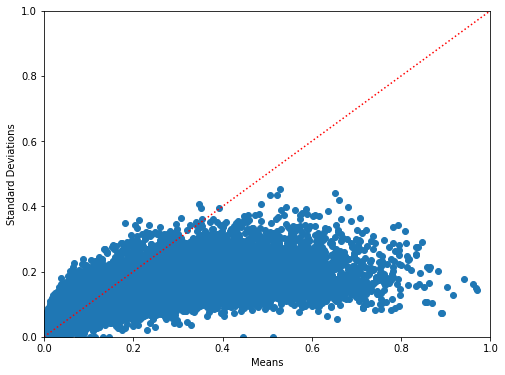

In [62]:
all_means = effnet_genre_mean.values.flatten()
all_stds = effnet_genre_std.values.flatten()

plt.figure(figsize=(8, 6))
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.scatter(all_means, all_stds)
plt.plot([0, 1],":", c= "r" )
plt.xlabel("Means")
plt.ylabel("Standard Deviations");

The vast majority of means are larger than their standard deviation counterparts. However the standard deviations are a little too high for my liking. It indicates that for a good number of songs the presence of a genre can significantly fluctuate. 

I'm going to keep researching this matter but for the mean time I'll have to stick to taking the mean.

### The Ear test

Now it's time to audit the effectiveness of the mean scores produced by the effnet model by applying the ear test.

I'm going to rate the quality of the scores in relation to how well they appraise the songs.

But first up, let's look at the genres with the highest scores.

20 highest scoring genres

In [63]:
top20 = effnet_genre_mean.mean().nlargest(20)
top20

electronic___house             0.307937
electronic___disco             0.193502
electronic___nu_disco          0.175915
electronic___deep_house        0.139706
funk__soul___disco             0.103610
funk__soul___funk              0.064744
electronic___synth_pop         0.055425
electronic___downtempo         0.049738
electronic___electro           0.046799
electronic___techno            0.044760
electronic___italo_disco       0.040917
electronic___tech_house        0.035971
funk__soul___boogie            0.035132
electronic___euro_disco        0.029326
electronic___tropical_house    0.028575
electronic___garage_house      0.026812
electronic___italo_house       0.026561
funk__soul___soul              0.026236
electronic___tribal_house      0.025624
electronic___vaporwave         0.024625
dtype: float32

Instead of using the mean of the genre, let's try applying a classification threshold of 0.5 to the scores.

Using this threshold we can tally the genre frequency in the data.

In [65]:
(effnet_genre_mean>=0.5).sum().nlargest(25)

electronic___house                612
electronic___disco                201
electronic___nu_disco             137
funk__soul___disco                 56
electronic___deep_house            32
electronic___italo_disco           27
electronic___vaporwave             21
electronic___euro_disco            20
funk__soul___funk                  12
pop___bubblegum                     8
electronic___techno                 7
folk_world__country___african       7
folk_world__country___zouk          7
electronic___italo_house            6
electronic___tribal_house           6
funk__soul___boogie                 6
electronic___garage_house           4
electronic___tropical_house         4
electronic___euro_house             3
electronic___synth_pop              3
folk_world__country___soukous       3
electronic___new_beat               2
electronic___progressive_house      2
electronic___synthwave              2
electronic___uk_garage              2
dtype: int64

Visualize the distribution of scores of the top 20 genres.

Here are 20 histograms of activation scores displayed with log scale on the y axis

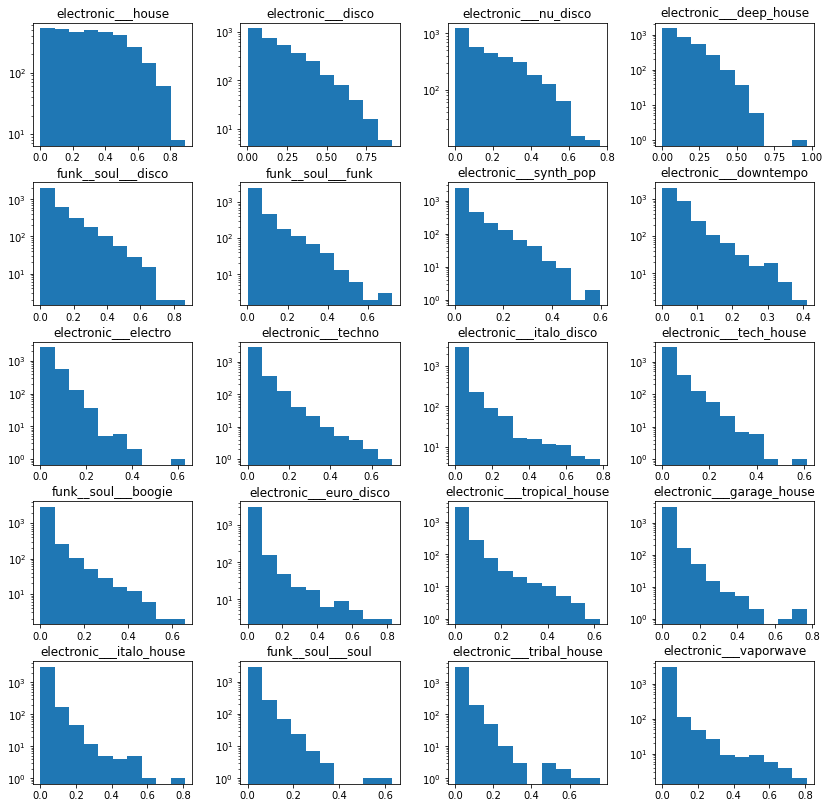

In [67]:
effnet_genre_mean.loc[:, top20.index].hist(figsize =(14, 14), grid = False, log=True);

### Time for the listening test.

I go through several of the genres and listen to a selection of their highest scoring songs. I listen a mix of the more common and rare genres present in my collection.

**Electronic Disco**

Here are the top ten `electronic___disco` songs.

I create a function called `top_songs` to create a dataframe of the top ten songs based on their scores for a specific genre.

In [79]:
def top_songs(col, n = 10):
    top_scores = effnet_genre_mean[col].nlargest(n)
    return pd.concat([tags, top_scores], axis = 1).dropna(subset=[col])[["title",
                                                               "artist", 
                                                               col]].sort_values(by = col,ascending=False)

In [86]:
top_elec_disco_songs = top_songs("electronic___disco")
top_elec_disco_songs


,title,artist,electronic___disco
sid,,,
068bbbe05d6aaf5fbbee4a89b65eba95,It's Too Funky In Here,Naughty Daughty,0.915107
32dfa61afcde29e346c0e69acde06d42,Estrela Saga,Joutro Mundo,0.864595
ec4c83b1b9e9056c988fff2c5b70f72f,Friday Night (V4YS Sax & Sun Edit)_PN,None,0.862622
0c25e323e108380754297c1273bf7917,Be My Lover,THOMA CHER,0.851176
190a813d592143fc5b923f9c330ea998,Bernardo Pinheiro - Quero pouco quero muito (B...,None,0.837809
1a734b77092397d92fbef3e112bc56b7,Let Yourself Be Free (Original Mix),The Funk District,0.833462
3992e51842f80423b696cb88b329a1d8,Freaky Stuff,The Funk District,0.817392
469dfe1aca4a3383ecee373e1bc3c0d2,Monkey Boogie (Original Mix)_PN,Paul Older,0.795834
b2f68fb4da37831583ed1829a48e3cf8,Timothy's Naked Globe Groove,Sosilly Edits,0.783449


Based on my initial read, this makes sense. I certainly don't dispute disco character of these tracks.

If you'd like to give the ear test a try, listen to the top five songs below.

1. It's Too Funky In Here - Naughty Daughty

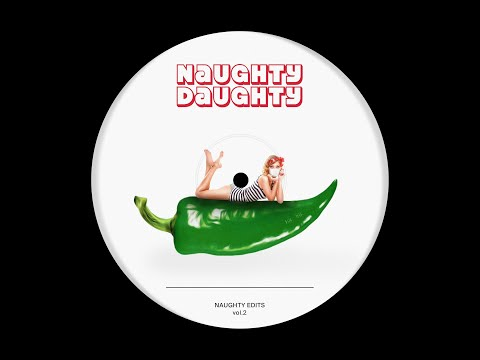

In [88]:
YouTubeVideo('zLAjlx0NfhM')

2. Estrela Saga	- Joutro Mundo

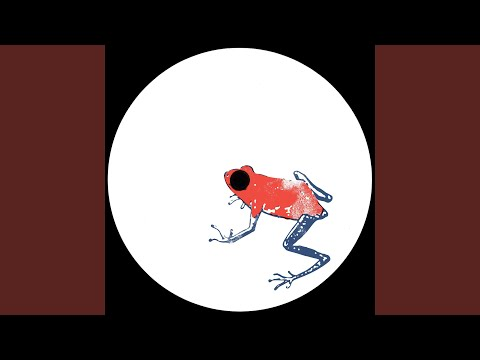

In [89]:
YouTubeVideo('XCkpNH8nu-k')

3. Friday Night (V4YS Sax & Sun Edit) - Teaspoon & The Waves

In [92]:
%%html
<iframe width="50%" height="200" scrolling="no" frameborder="no" allow="autoplay" src="https://w.soundcloud.com/player/?url=https%3A//api.soundcloud.com/tracks/1048879345&color=%23ff5500&auto_play=false&hide_related=false&show_comments=true&show_user=true&show_reposts=false&show_teaser=true&visual=true"></iframe><div style="font-size: 10px; color: #cccccc;line-break: anywhere;word-break: normal;overflow: hidden;white-space: nowrap;text-overflow: ellipsis; font-family: Interstate,Lucida Grande,Lucida Sans Unicode,Lucida Sans,Garuda,Verdana,Tahoma,sans-serif;font-weight: 100;"><a href="https://soundcloud.com/vibes4yoursoul" title="Vibes4YourSoul" target="_blank" style="color: #cccccc; text-decoration: none;">Vibes4YourSoul</a> · <a href="https://soundcloud.com/vibes4yoursoul/teaspoon-the-waves-friday-night-v4ys-sax-sun-edit" title="Teaspoon &amp; The Waves - Friday Night (V4YS Sax &amp; Sun Edit)" target="_blank" style="color: #cccccc; text-decoration: none;">Teaspoon &amp; The Waves - Friday Night (V4YS Sax &amp; Sun Edit)</a></div>

4. Be My Love - Thoma Cher

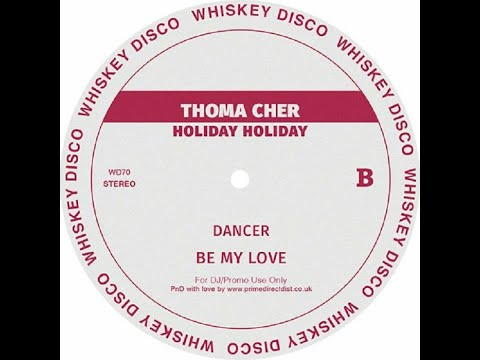

In [93]:
YouTubeVideo('DCBZWX65zig')